# Optimized MIDAA Unsupervised Model (CLEAN) run on the balanced dataset
This notebook runs an optimized, unsupervised MIDAA model with improved code clarity, reproducibility, and hyperparameter selection.
Same as the other CLEAN notebook, just ona  new datset

Code was developed using https://sottorivalab.github.io/midaa/scMulti_multimodal.html for instruction on MIDAA application, and LLMs to aid code writing

In [1]:
import midaa as maa
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import os

c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if device.type == 'cuda':
    torch.set_default_dtype(torch.float32)

In [ ]:
# Load AnnData BALANCED
adata_path = r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Data\Antibiotic resistance\BacDrop\further processing\random_adata_balanced.h5ad"
assert os.path.exists(adata_path), f'File not found: {adata_path}'
adata = sc.read_h5ad(adata_path)
print(f'Loaded AnnData with shape: {adata.shape}')

In [ ]:
# Prepare MIDAA input
input_data_raw, normalization_raw, input_distribution = maa.get_input_params_adata(adata)

def scipy_to_torch_sparse(csr_mat, device):
    coo = csr_mat.tocoo()
    indices = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long, device=device)
    values = torch.tensor(coo.data, dtype=torch.float32, device=device)
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, shape).coalesce()

def convert_input_list(data_list):
    torch_list = []
    for x in data_list:
        if issparse(x):
            torch_list.append(scipy_to_torch_sparse(x, device))
        else:
            if isinstance(x, torch.Tensor):
                torch_list.append(x.to(device=device, dtype=torch.float32))
            else:
                torch_list.append(torch.tensor(x, dtype=torch.float32, device=device))
    return torch_list

input_data = convert_input_list(input_data_raw)
normalization = convert_input_list(normalization_raw)

In [ ]:
# Hyperparameters
MULT = 4  # Network width multiplier to easily scale 
archetype_range = range(5, 6)  # change range as needed 
steps = 2000  # training steps 
lr = 5e-4  #  learning rate
batch_size = 4096  # batch size
torch_seed = 42  # for reproducibility
results = {}

In [ ]:
# Ensure cuda is being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# make GPU the default for all new tensors
if device.type == "cuda":
    # Any torch.tensor(...) from now on will live on cuda:0
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [ ]:
#Run MIDAA for a range of archetypes
for narchetypes in archetype_range:
    print([x.device for x in input_data])
    print([x.device for x in normalization])
    print(f'\n--- Training with {narchetypes} archetypes ---')
    result = maa.fit_MIDAA(
        input_data,
        normalization,
        input_distribution,
        hidden_dims_dec_common=[64 * MULT, 128 * MULT],
        hidden_dims_dec_last=[256 * MULT],
        hidden_dims_enc_ind=[128 * MULT],
        hidden_dims_enc_common=[64 * MULT],
        hidden_dims_enc_pre_Z=[32 * MULT],
        lr=lr,
        gamma_lr=0.1,
        steps=steps,
        narchetypes=narchetypes,
        batch_size=batch_size,
        torch_seed=torch_seed,
    )
    results[narchetypes] = result  # Save the full result dict!
    print(f'Final ELBO for {narchetypes} archetypes: {result["ELBO"][-1]:.2f}')

In [ ]:
# Plot ELBO curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for narchetypes, result in results.items():
    plt.plot(result['ELBO'], label=f'{narchetypes} archetypes')
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO curves for different archetype numbers')
plt.legend()
plt.show()

In [ ]:
#plot final ELBO for each archetype
final_elbos = {narchetypes: result['ELBO'][-1] for narchetypes, result in results.items()}
plt.figure(figsize=(8, 5))
plt.plot(list(final_elbos.keys()), list(final_elbos.values()), marker='o')
plt.xlabel('Number of archetypes')
plt.ylabel('Final ELBO')
plt.title('Final ELBO for each archetype number')
plt.savefig("ELBO_2307rand.png")  # Save the plot as requested
plt.show()

## Model Selection
You can select the best number of archetypes based on the ELBO curve and downstream biological interpretability.

In [ ]:
import pickle
import torch

# Find the best model (elbow from elbo plot)
best_narch = 5  # Integer instead of list
date_str = "1507" #DDMM  

print(f"Best number of archetypes: {best_narch}")

# Extract only the picklable data from best_result
best_result = results[best_narch]

# Create a clean dictionary with only picklable data
saveable_data = {
    "inferred_quantities": {},
    "ELBO": best_result["ELBO"],
    "hyperparameters": best_result["hyperparameters"]
}

# Extract and convert tensors to numpy arrays for the inferred quantities
for key, value in best_result["inferred_quantities"].items():
    if isinstance(value, torch.Tensor):
        saveable_data["inferred_quantities"][key] = value.detach().cpu().numpy()
    else:
        saveable_data["inferred_quantities"][key] = value

# Save the clean result dictionary with date
result_filename = f"best_midaa_result_{best_narch}arch_{date_str}.pkl"
with open(result_filename, "wb") as f:
    pickle.dump(saveable_data, f)
print(f"Successfully saved clean result dictionary to {result_filename}")

# Save the model state dict (model weights) with date
if "deepAA_obj" in best_result:
    model_filename = f"best_midaa_model_{best_narch}arch_{date_str}.pth"
    torch.save(best_result["deepAA_obj"].state_dict(), model_filename)
    print(f"Successfully saved model weights to {model_filename}")
else:
    print("Warning: No 'deepAA_obj' found in best_result")

In [2]:
#reloading outputs of old model
import pickle

# Load the metadata/results dictionary
with open(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\output\2307_rand\best_midaa_result_5arch_2307_rand.pkl", "rb") as f:
    best_result = pickle.load(f)

# Access the outputs
inferred_quantities = best_result["inferred_quantities"]  # e.g., A, B, Z matrices
ELBO = best_result["ELBO"]
hyperparameters = best_result["hyperparameters"]

# get the archetype assignment matrix A
A = inferred_quantities["A"]
B = inferred_quantities["B"]
Z = inferred_quantities["Z"]

# Now you can use A, B, Z, ELBO, etc. for downstream analysis!

In [ ]:
# #importing everything at once 
# import pickle

# with open(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\output\1507\best_midaa_result_5arch_1507.pkl", "rb") as f:
#     best_result = pickle.load(f)

## Post processing to get data into form for cross model comparison
1. Completing p-value analysis:
    a. Calulating archetype coordinates in latent space 
    b. Calculating simplex volume in latent space 
    c. calculating original data volume in latent space
    d. calculate real t-ratio
    e. calculating randomised t-ratios in latent space
    f. exporting required variables for p-values 


In [3]:
#leveraging functinos developed for this purpose in AA_downstream_analysis.py
import sys
sys.path.append(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Analysis")
import AA_downstream_analysis
from AA_downstream_analysis import compute_simplex_volume, compute_convex_hull_volume, randomize_Z, null_t_ratios


c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Completing p-value analysis

#### a. Archetype coordinates in latent space 
Using a numpy function for linear least squares problem to solve for the arcehtypes coordinate in latent space. 

In [5]:
import numpy as np

In [6]:
# Solve for archetype coordinates in latent space
# This solves Z = A @ archetypes_latent for archetypes_latent
archetypes_latent, residuals, rank, s = np.linalg.lstsq(A, Z, rcond=None) #rcond=None to use default machine prevision for cutting of singular values for psuedo inverse of A

print("Archetype coordinates in latent space (shape: n_archetypes x latent_dim):")
print(archetypes_latent)
print(archetypes_latent.shape) #should be num of archetypes x latent dim, where latent dim is num of arhcetypes - 1

Archetype coordinates in latent space (shape: n_archetypes x latent_dim):
[[-1.036547   -0.60861844  0.12414005 -0.20417362]
 [-0.1463315   0.4342716  -0.9729837   0.18484037]
 [ 0.6151094   0.52910006 -0.45268545  0.43791524]
 [-0.02292774 -0.3733423   0.7803191  -0.57385194]
 [-0.11029071 -0.60482514  0.53168076  0.9462463 ]]
(5, 4)


#### b. Calculating the real simplex volume in latent space
Based on the same code that ParTI does to calculate the simplex volume in findMinSimplex.m function

In [7]:
# archetypes_latent: (N, d) where N = n_archetypes, d = latent_dim (should be N-1 for a full simplex)
real_simplex_volume = compute_simplex_volume(archetypes_latent)

print("Real simplex volume:", real_simplex_volume)


Real simplex volume: 0.004995174705982208


#### c. calculating the complex hull of the original data in latent space
Leveraging the Z matrix generated by MIDAA.fit, and using convexhull functions from scipy to calculate the volume

In [15]:
# Calculate the convex hull and its volume
real_convex_hull_volume = compute_convex_hull_volume(Z)

print("Convex hull volume of the data in latent space:", convex_hull_volume)

Convex hull volume of the data in latent space: 1.573638213311249


#### d. calculate real t-ratio
Equivalent to ParTI: simplex vol / convex hull vol

In [16]:
tRatioReal = real_simplex_volume / convex_hull_volume
print ("tRatioReal: ", tRatioReal)

tRatioReal:  0.003174284065885362


#### e. calculating randomised t-ratios in latent space
Match to ParTI method:
1. Randomly permute data along each latent dimensions independently 
2.Fit the polytope (keeping # arhcetypes the same) on the randomised data 
3. calculate t-ratio for the randomised dataset 
4. repeat 10000 times to create a distribution

In [17]:
def null_t_ratios_QC(A, Z, n_random=1000): 
    t_ratios = []
    simplex_vols = []
    hull_vols = []
    n_archetypes = A.shape[1]
    for _ in range(n_random):
        # Randomise the latent space
        Z_rand = randomize_Z(Z)
        # Solve for new archetype coordinates in the randomised latent space for the same A and number of archetypes
        archetypes_latent_rand, *_ = np.linalg.lstsq(A, Z_rand, rcond=None) #solved using least squares, same as the real t-ratio model

        ########### QC on the randomised latent space ###########
        # Check if the randomly generated latent space is not the expected dimension
        if Z_rand.shape[1] != A.shape[1]-1:
            print(f"Error: Randomly generated latent space has dimension {Z_rand.shape[1]}, expected {A.shape[1]-1}.")
        
        if np.linalg.matrix_rank(archetypes_latent_rand) < archetypes_latent_rand.shape[1]:
            # Degenerate simplex, skip or set t-ratio to np.nan
            print("Degenerate simplex")
            t_ratios.append(np.nan)
            simplex_vols.append(np.nan)
            hull_vols.append(np.nan)
            continue
        #########################################################

        # Simplex volume
        simplex_vol = compute_simplex_volume(archetypes_latent_rand)
        # Convex hull volume
        hull_vol = compute_convex_hull_volume(Z_rand)
        # t-ratio
        t_ratios.append(simplex_vol / hull_vol) #simplex over convex hull
        simplex_vols.append(simplex_vol)
        hull_vols.append(hull_vol)

    return t_ratios, simplex_vols, hull_vols, Z_rand, archetypes_latent_rand

In [18]:
n_random = 1000
t_ratios_null, simplex_vols_null, hull_vols_null, Z_rand, archetypes_latent_rand = null_t_ratios_QC(A, Z, n_random=n_random)

#### f. Calculating the p value 
Given MIDAA's volume is smaller than the convex hull for the simplex, extreme values of t are taken as ones that are larger (Closer to 1)


In [19]:
#using mean to get the p-value
p_value = np.mean(t_ratios_null >= tRatioReal)
print(f"p-value: {p_value:.100f}")

p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


### Assessing process through visualisation


Visualising position of real t-ratio in the null distribution via histogram

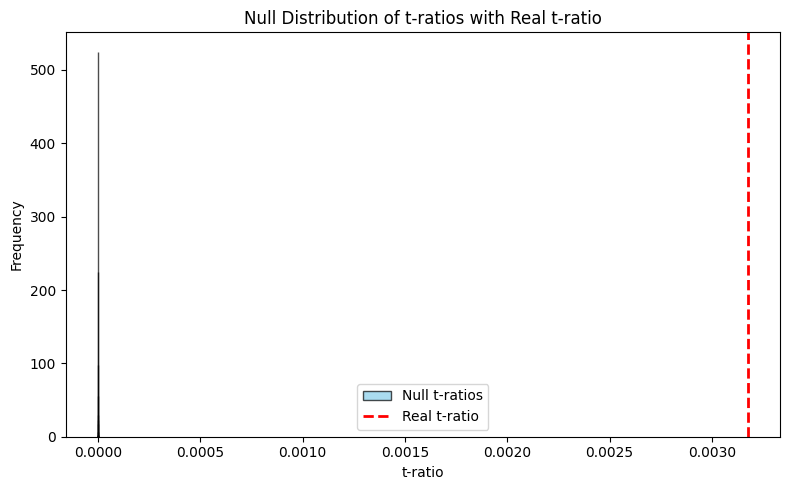

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(t_ratios_null, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Null t-ratios')
plt.axvline(tRatioReal, color='red', linestyle='dashed', linewidth=2, label='Real t-ratio')
plt.xlabel('t-ratio')
plt.ylabel('Frequency')
plt.title('Null Distribution of t-ratios with Real t-ratio')
plt.legend()
plt.tight_layout()
plt.show()


Plotting distribution of random vs real convex hull and simplex volumes

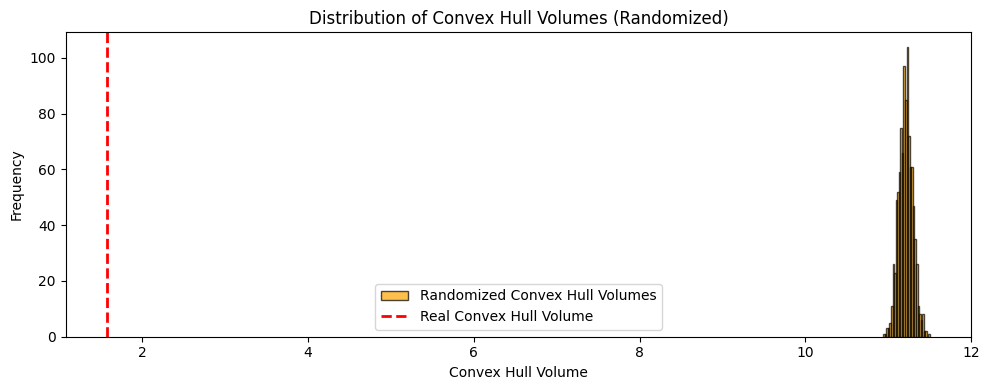

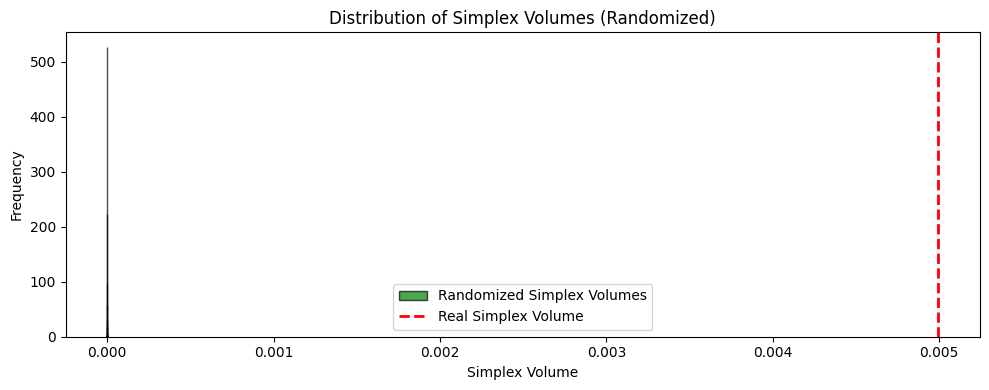

In [21]:
    # Plot the distribution of convex hull volumes with real value

    valid_hull_vols = hull_vols_null

    plt.figure(figsize=(10,4))
    plt.hist(valid_hull_vols, bins=30, color='orange', edgecolor='black', alpha=0.7, label='Randomized Convex Hull Volumes')
    plt.axvline(real_convex_hull_volume, color='red', linestyle='dashed', linewidth=2, label='Real Convex Hull Volume')
    plt.xlabel('Convex Hull Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Convex Hull Volumes (Randomized)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot the distribution of simplex volumes with real value
    valid_simplex_vols = simplex_vols_null
    plt.figure(figsize=(10,4))
    plt.hist(valid_simplex_vols, bins=30, color='green', edgecolor='black', alpha=0.7, label='Randomized Simplex Volumes')
    plt.axvline(real_simplex_volume, color='red', linestyle='dashed', linewidth=2, label='Real Simplex Volume')
    plt.xlabel('Simplex Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Simplex Volumes (Randomized)')
    plt.legend()
    plt.tight_layout()
    plt.show()


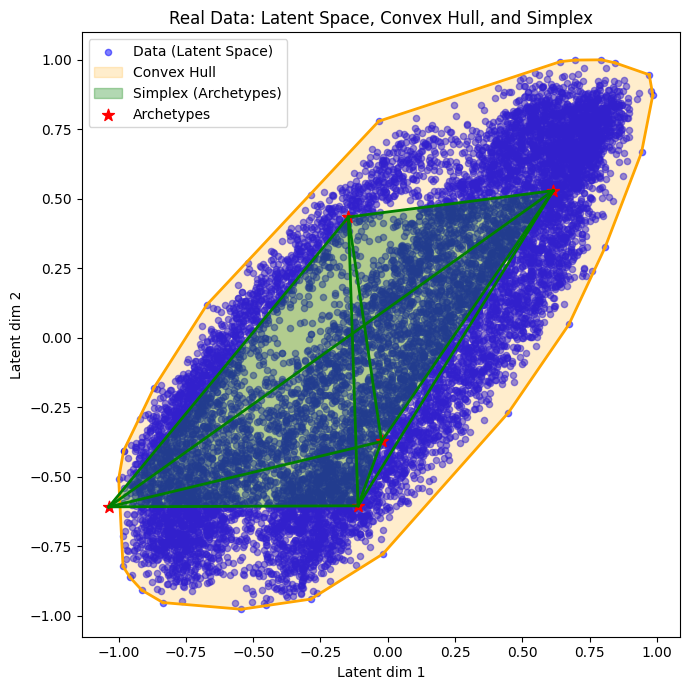

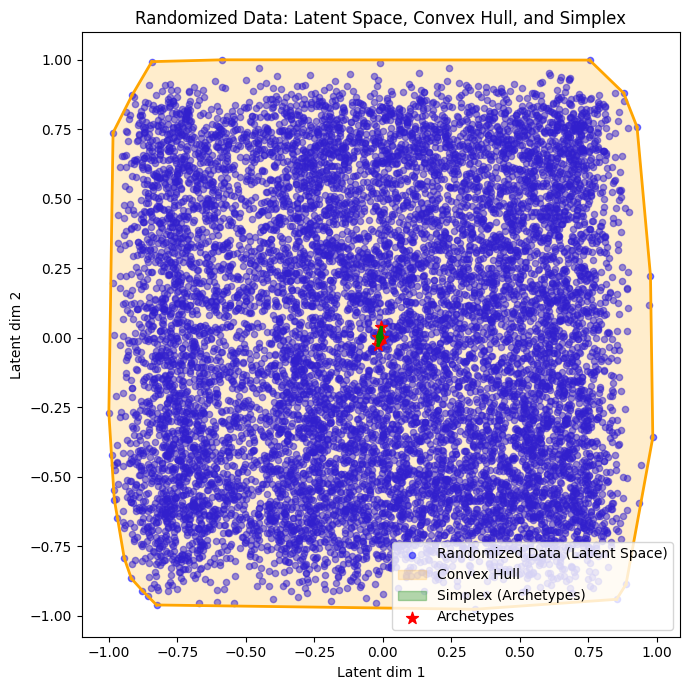

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Helper function to plot convex hull
def plot_convex_hull(ax, points, hull, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull'):
    for simplex in hull.simplices:
        simplex_points = points[simplex]
        ax.plot(simplex_points[:, 0], simplex_points[:, 1], '-', color=edgecolor, lw=2)
    # Fill the hull
    hull_path = points[hull.vertices]
    ax.fill(hull_path[:, 0], hull_path[:, 1], color=color, alpha=alpha, label=label)

# Helper function to plot simplex
def plot_simplex(ax, simplex_points, color='green', alpha=0.3, edgecolor='green', label='Simplex'):
    # Draw lines between all pairs of simplex vertices
    n = simplex_points.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            ax.plot([simplex_points[i, 0], simplex_points[j, 0]],
                    [simplex_points[i, 1], simplex_points[j, 1]],
                    color=edgecolor, lw=2)
    # Fill the simplex
    ax.fill(simplex_points[:, 0], simplex_points[:, 1], color=color, alpha=alpha, label=label)

# --- Plot for real data ---
# Project to first 2 latent dimensions
Z_2d = Z[:, :2]
archetypes_latent_2d = archetypes_latent[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1], s=20, color='blue', alpha=0.5, label='Data (Latent Space)')
# Convex hull
hull_real = ConvexHull(Z_2d)
plot_convex_hull(ax, Z_2d, hull_real, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, archetypes_latent_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(archetypes_latent_2d[:, 0], archetypes_latent_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('Real Data: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()

# --- Plot for first randomised dataset in null distribution ---
# Assume Z_rand is the first randomised latent space (from null_t_ratios or randomize_Z)
Z_rand_2d = Z_rand[:, :2]
# Get archetypes for the first randomised dataset
archetypes_latent_rand_2d = archetypes_latent_rand[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(Z_rand_2d[:, 0], Z_rand_2d[:, 1], s=20, color='blue', alpha=0.5, label='Randomized Data (Latent Space)')
# Convex hull
hull_rand = ConvexHull(Z_rand_2d)
plot_convex_hull(ax, Z_rand_2d, hull_rand, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, archetypes_latent_rand_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(archetypes_latent_rand_2d[:, 0], archetypes_latent_rand_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('Randomized Data: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()
